In [1]:
# Import libraries
import os
import cv2
import imutils
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import pickle

from skimage.feature import hog
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Config display
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Sample image
imageFileName = 'image-260nw-205266196.jpg'
imagePath = os.path.join(
    'data', 'carLogo', 'Train' , 'hyundai', imageFileName
)

# Define image show function
def imageShow(data, convert = True, gray = False):
    if convert is True:
        data = data[:, :, ::-1] #RGB-> BGR
    if gray is True:
        color = 'gray'
    else:
        color = None
    plt.imshow(data, cmap = color)
    plt.axis('off')
    return plt.show()

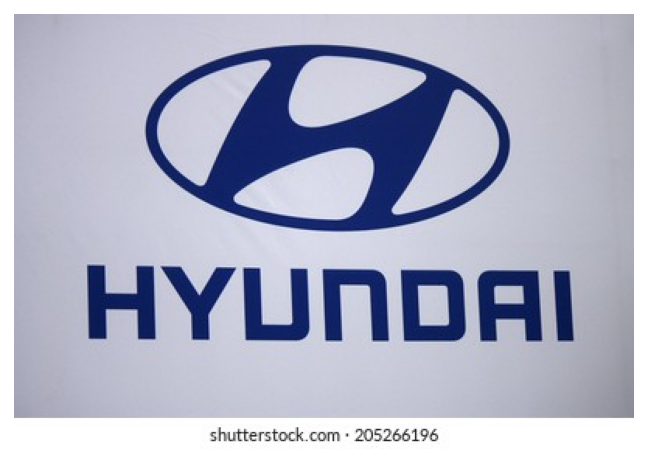

In [3]:
# Show original image
image = cv2.imread(imagePath)
imageShow(image, convert = True, gray = False)


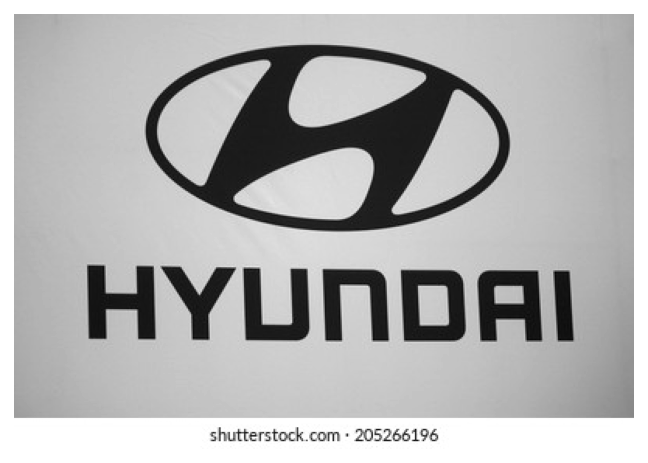

In [4]:
# Covert original to gray scale
imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
imageShow(imageGray, convert = False, gray = True)

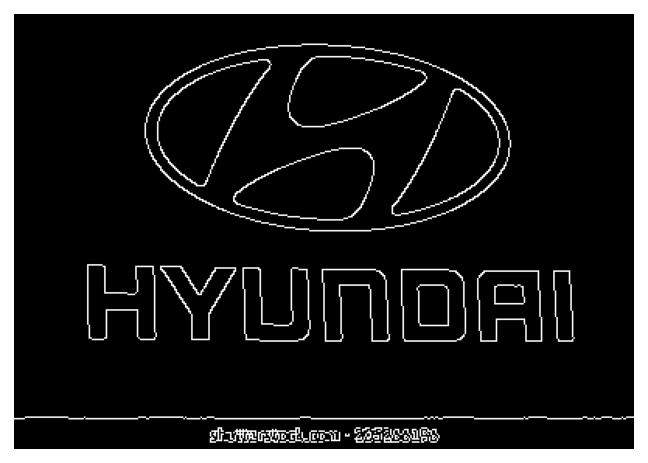

In [5]:
# Extract edge image
imageEdge = imutils.auto_canny(imageGray)
imageShow(imageEdge, convert = False, gray = True)

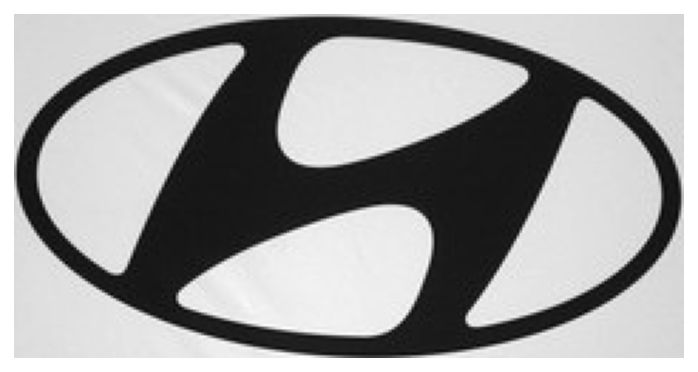

In [6]:
# Find shape from edge image
imageShape = cv2.findContours(
    imageEdge.copy(),
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE
)
imageShape = imutils.grab_contours(imageShape)
c = max(imageShape, key = cv2.contourArea)

# Extract the logo from image
(x, y, w, h) = cv2.boundingRect(c)
logo = imageGray[y:y + h, x:x + w]

# Show logo image
imageShow(logo, convert = False, gray = True)

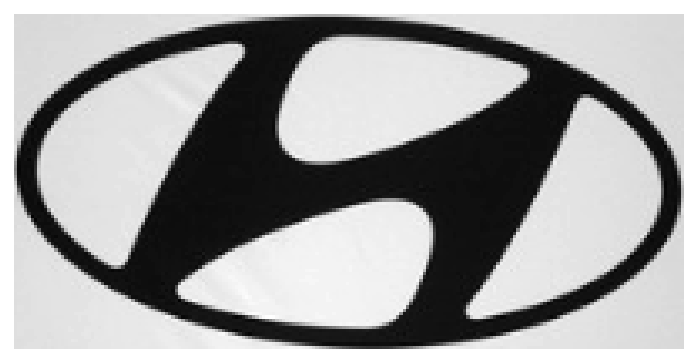

In [7]:
# Resize image to 2:1 (for HOG)
logoResize = cv2.resize(logo, (200, 100))
imageShow(logoResize, convert = False, gray = True)

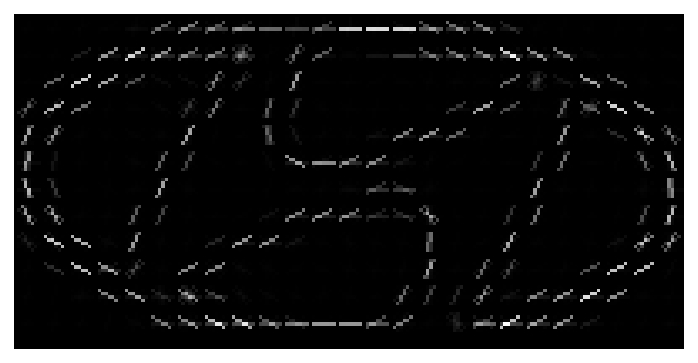

In [8]:
# Extract HOG
_, HOGImage = hog(
	logoResize,
	orientations = 9,
	pixels_per_cell = (8, 8),
	cells_per_block = (2, 2),
	visualize = True #Set to show image
)

imageShow(HOGImage, convert = False, gray = True)

In [9]:
# Create dataset
folderPath = os.path.join(
    'data', 'carLogo', 'Train'
)
folderList = [label for label in os.listdir(folderPath) if not label.startswith('.')]

data = []
labels = []

for label in folderList:
    print(f'Processing car bard: {label}')
    imagePath = os.path.join(folderPath, label)
    images = []
    bands = []
    for file in os.listdir(imagePath):
        if not file.startswith('.'):
            imageFile = os.path.join(imagePath, file)
        image = cv2.imread(imageFile)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        edge = imutils.auto_canny(gray)
        shape = cv2.findContours(
            edge.copy(),
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE
        )
        shape = imutils.grab_contours(shape)
        c = max(shape, key = cv2.contourArea)
        (x, y, w, h) = cv2.boundingRect(c)
        logo = gray[y:y + h, x:x + w]
        logo = cv2.resize(logo, (200, 100))
        HOGImage = hog(
	        logo,
            orientations = 9,
            pixels_per_cell = (10, 10),
            cells_per_block = (2, 2),
            transform_sqrt = True,
            block_norm = 'L1'
        )
        images.append(HOGImage)
        bands.append(label)
    data.extend(images)
    labels.extend(bands)


Processing car bard: volkswagen
Processing car bard: mazda
Processing car bard: hyundai
Processing car bard: mercedes
Processing car bard: opel
Processing car bard: toyota
Processing car bard: lexus
Processing car bard: skoda


In [10]:
# Convert to numpy array
data = np.array(data, dtype = 'float32')
labels = np.array(labels)

# Export dataset
pickle.dump(data, open('HOGCars.pk', 'wb'))
pickle.dump(labels, open('labelCars.pk', 'wb'))

In [11]:
# Shuffle development dataset
X, y = shuffle(data, labels)

In [12]:
# Find number of neighbors with CV
scores = []

for n in range(5, 16):
    model = KNeighborsClassifier(n_neighbors = n, n_jobs = -1)    
    accuracy = cross_val_score(
        model,
        X, y,
        cv = 10
    )
    scores.append(accuracy.mean())

nBest = np.argmax(scores) + 5 #Start at 5

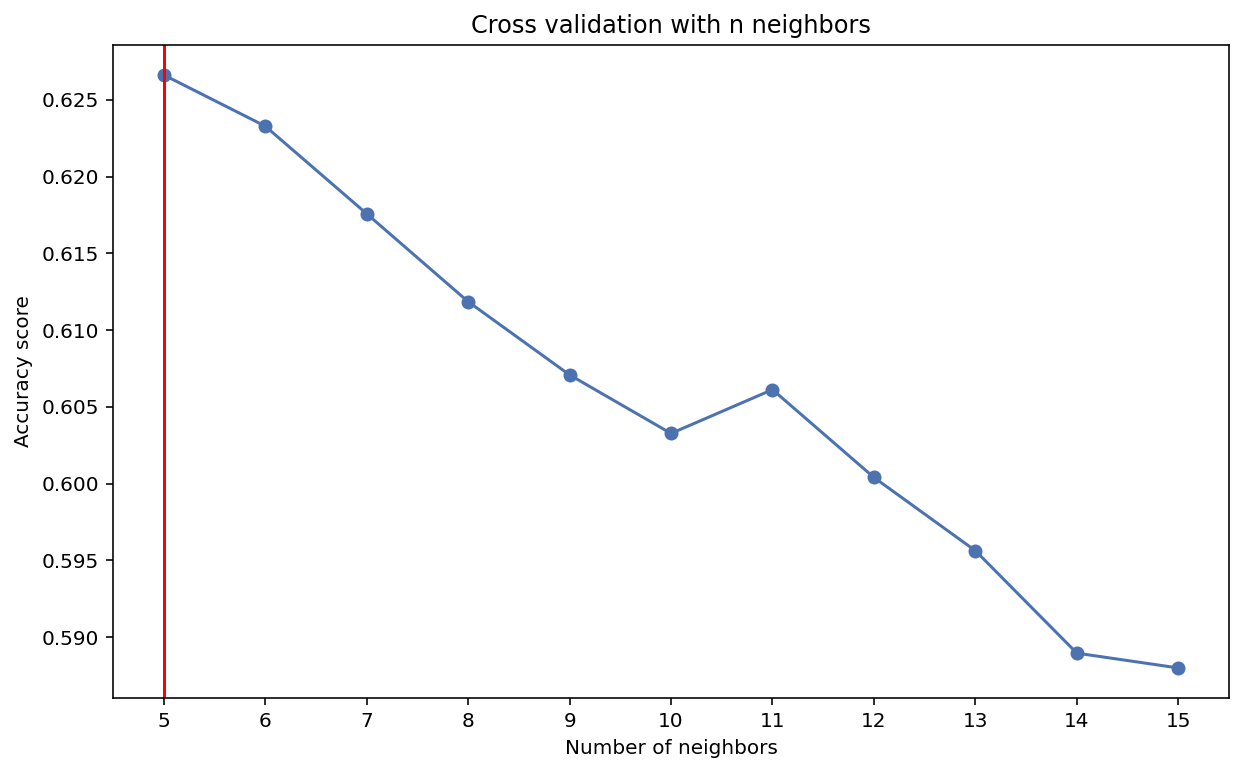

In [13]:
# Plot
plt.figure(figsize = (10, 6))
with plt.style.context('seaborn-deep'):
    plt.plot(
        scores,
        marker = 'o'
    )
    plt.title('Cross validation with n neighbors')
    plt.xlabel('Number of neighbors')
    plt.xticks(
        np.arange(len(scores)),
        np.arange(5, len(scores) + 5)
    )
    plt.axvline(np.argmax(scores), c = 'red')
    plt.ylabel('Accuracy score')
plt.show()

In [14]:
# KNN Classifier
model = KNeighborsClassifier(n_neighbors = nBest)
model.fit(X, y)

print(f'Model score: {model.score(X, y) * 100:.2f}%')

Model score: 76.87%


In [15]:
# Model performance report
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

     hyundai       0.88      0.79      0.84       248
       lexus       0.65      0.87      0.75       246
       mazda       0.72      0.85      0.78       296
    mercedes       0.59      0.88      0.71       295
        opel       0.92      0.65      0.76       235
       skoda       0.94      0.79      0.86       263
      toyota       0.96      0.59      0.73       254
  volkswagen       0.85      0.68      0.75       260

    accuracy                           0.77      2097
   macro avg       0.81      0.76      0.77      2097
weighted avg       0.81      0.77      0.77      2097



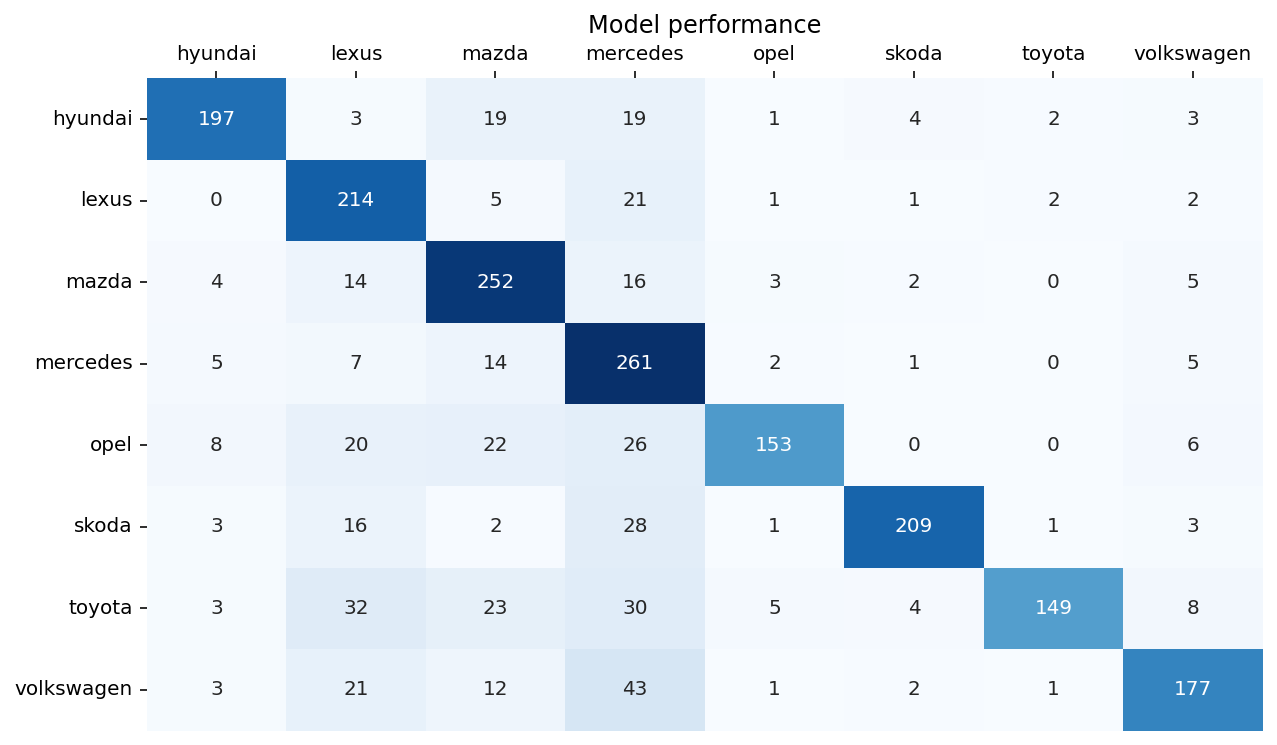

In [16]:
# Model performance
CFMatrix = pd.crosstab(y, model.predict(X))

# Plot
plt.figure(figsize = (10, 6))
plt.title('Model performance')
ax = sns.heatmap(CFMatrix,
            annot = True,
            fmt = 'g',
            xticklabels = True,
            yticklabels = True,
            cmap = plt.cm.Blues,
            cbar = False)
ax.xaxis.tick_top() # x-axis on top
ax.xaxis.set_label_position('top')
ax.set(xlabel = '', ylabel = '')
plt.show()


In [17]:
# Export model
pickle.dump(model, open('modelHOGCars.pk', 'wb'))

In [18]:
# Define function for prediction
def predictionLogo(fileName):
    imageFile = os.path.join(
        'data', 'carLogo', fileName
    )
    image = cv2.imread(imageFile)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    logo = cv2.resize(gray, (200, 100))
    HOGImage = hog(
        logo,
        orientations = 9,
        pixels_per_cell = (10, 10),
        cells_per_block = (2, 2),
        transform_sqrt = True,
        block_norm = 'L1'
    )
    predLabel = model.predict(HOGImage.reshape(1, -1))[0]
    cv2.putText(
        image,
        predLabel,
        (10, 35),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.5,
        (0, 255, 0),
        3
    )
    plt.imshow(image[:, :, ::-1]) #RGB-> BGR
    plt.axis('off')
    return plt.show()

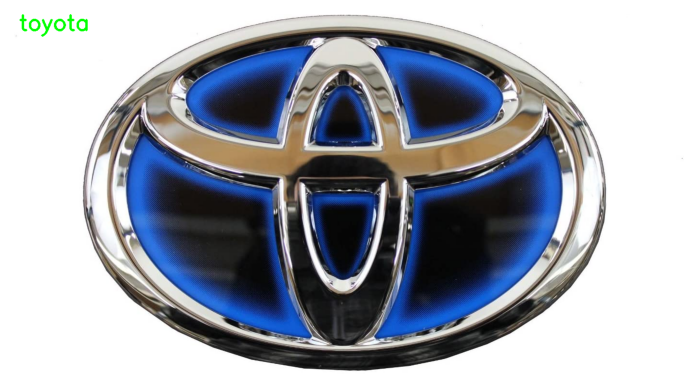

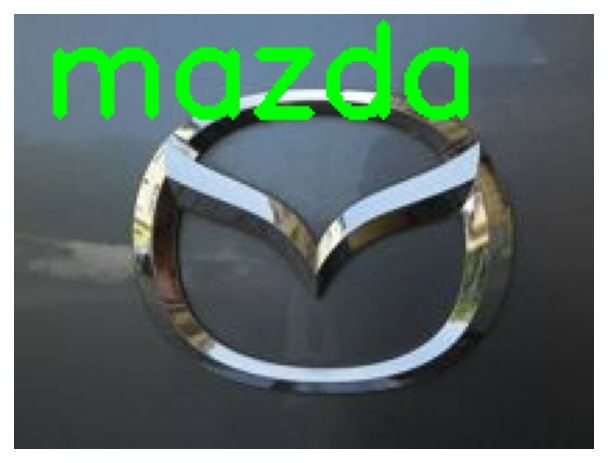

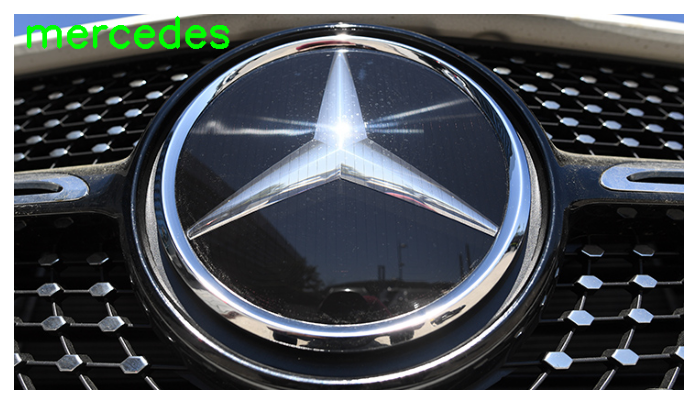

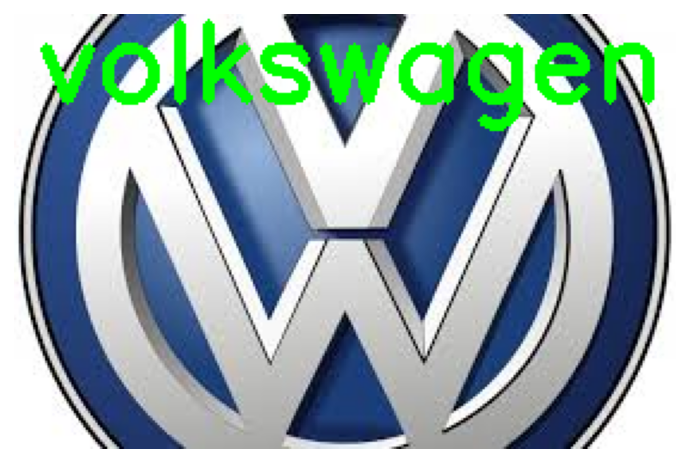

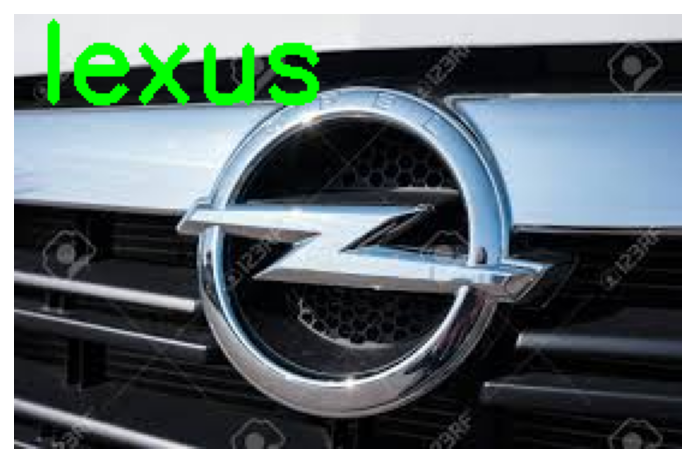

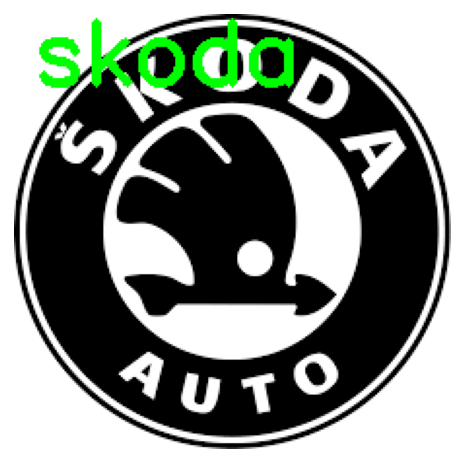

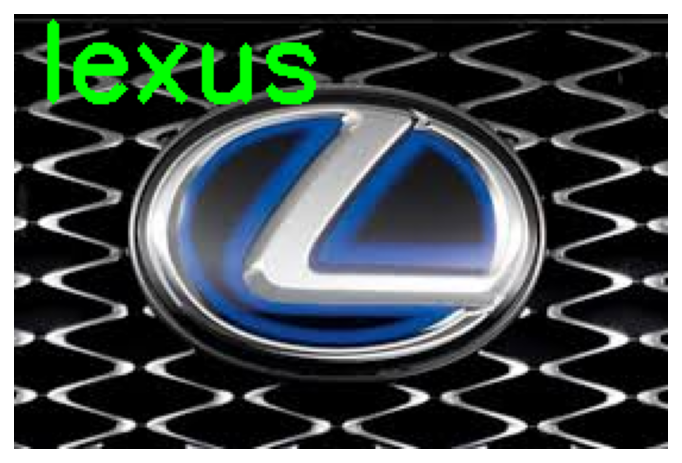

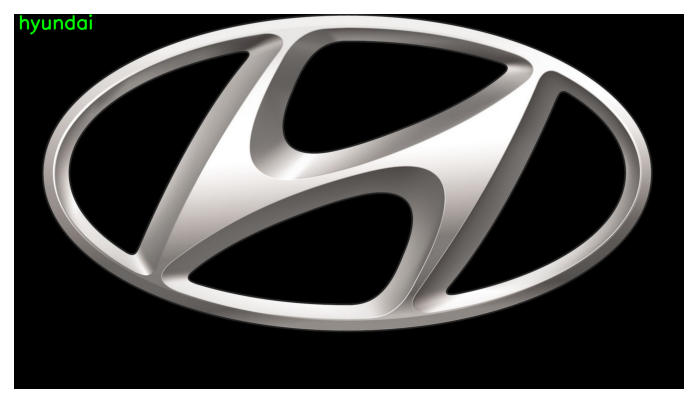

In [19]:
# Prediction
filesTest = [file for file in os.listdir(os.path.join('data', 'carLogo')) if file.endswith('.jpg')]

for file in filesTest:
    predictionLogo(file)